In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
import finnhub
import time
import plotly.express as px
from random import sample

In [2]:
stocks2011 =  pd.read_csv("stocks2011_inall.csv")

In [3]:
stocks2011.shape

(607, 12)

In [4]:
predictor_variables = stocks2011[['debtRatio','returnOnAssets','priceBookValueRatio','priceToFreeCashFlowsRatio','priceEarningsRatio','priceEarningsToGrowthRatio','debtEquityRatio']]
col_names = list(predictor_variables.columns)

In [5]:
s_scaler = preprocessing.StandardScaler()

In [6]:
df_s = s_scaler.fit_transform(predictor_variables)
df = pd.DataFrame(df_s, columns=col_names)
df.head()

,debtRatio,returnOnAssets,priceBookValueRatio,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,debtEquityRatio
0,-0.511682,0.208897,0.185831,0.040160,0.232114,1.918342,-0.596793
1,-0.901104,0.244885,1.031638,-1.176075,0.911202,-0.315878,-0.670123
2,0.016857,0.025795,-0.324097,-0.235690,10.922340,-1.945081,-0.425429
3,-0.238235,0.136088,-0.373568,-0.183920,-0.048799,-0.151225,-0.522926
4,0.975713,0.041094,-0.477649,-0.005432,-0.086304,-0.047229,1.357712


In [7]:

# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(df)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [8]:
# inertia on the fitted data
kmeans.inertia_

3459.7733883107758

Text(0, 0.5, 'Inertia')

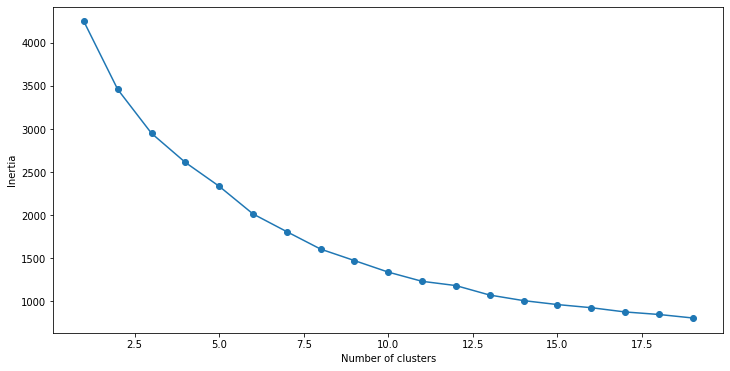

In [9]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(df)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [10]:
# k means using 8 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 8, init='k-means++')
kmeans.fit(df)
pred = kmeans.predict(df)

In [11]:
frame = pd.DataFrame(df)
frame['cluster'] = pred

clustered_2011 = frame
frame['cluster'].value_counts()

1    336
2    190
6     30
0     29
5     11
7      5
4      4
3      2
Name: cluster, dtype: int64

In [12]:
# add the date and symbols back on
clustered_2011['Date'] = stocks2011['date'].values
clustered_2011['Symbol'] = stocks2011['symbol'].values

 https://www.unixtimestamp.com/ was used to convert start and end to UNIX

In [15]:
def callCounter():
    callCounter.counter += 1
    print(callCounter.counter)
callCounter.counter = 0


finnhub_client = finnhub.Client(api_key="c7rah32ad3icp4g2mrig")
def getPrice(stock):
    try:
        res = finnhub_client.stock_candles(stock, 'D', 1293840000, 1325375940)
        df = pd.DataFrame(res)
        df["Symbol"] = stock
    except:
        data = [[0,0,0,0,0,0,0,stock]]
        df = pd.DataFrame(data, columns = ['c', 'h', 'l', 'o', 's', 't', 'v', 'Symbol'])
    return df

In [16]:
symbols11 = clustered_2011['Symbol'].to_list()
df_list = []

for ticker in symbols11:
    callCounter()
    if callCounter.counter %59 == 0:
        time.sleep(60)
    else:
        df1 = getPrice(ticker) 
        df_list.append(df1)

df_final_11 = pd.concat(df_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [17]:
df_final_11_symbols = df_final_11["Symbol"].unique()
annual_sharpe_ratio = {}
for stock in df_final_11_symbols:
    dataframe = df_final_11[df_final_11["Symbol"] == stock]
    data = dataframe[["c"]]
    log_return = np.sum(np.log(data/data.shift())*1, axis=1)
    sharpe_ratio = log_return.mean()/log_return.std()
    asr = sharpe_ratio*252**.5
    annual_sharpe_ratio[stock] = asr

sharpe_ratio2011 = pd.DataFrame(annual_sharpe_ratio.items(), columns = ["Symbol","Sharpe Ratio"])

In [33]:
df_all_2011 = clustered_2011.merge(df_final_11, on=['Symbol'], 
                   how='left', indicator=True)
mask_2011= df_all_2011["_merge"] == "left_only"
missedStocks_2011 = df_all_2011[mask_2011]
missedStocks_2011

,debtRatio,returnOnAssets,priceBookValueRatio,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,debtEquityRatio,cluster,Date,Symbol,c,h,l,o,s,t,v,_merge
13970,-1.252340,0.244760,0.255885,0.383095,0.446514,0.204607,-0.717005,1,2011-04-30,AVAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
28198,-0.908113,0.422776,1.341706,0.085274,0.388296,-0.138600,-0.671206,1,2011-06-30,CLCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
42523,-1.171077,0.518477,0.504399,0.116747,-0.036119,0.221289,-0.707348,1,2011-12-31,EBIX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
56402,0.673727,0.075122,-0.048251,-0.323260,0.170436,0.067876,0.197295,2,2011-12-31,GATX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
70353,-0.224641,0.278128,0.809873,-0.652737,0.211938,-0.165334,-0.518559,1,2011-12-31,IDCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
83996,0.934770,0.033661,-0.732485,0.243220,-0.262182,-0.059894,1.084690,2,2011-12-31,MFNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
97810,-0.231347,0.106283,-0.364046,-0.757319,0.145726,0.138382,-0.519945,1,2011-12-31,OLP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
112028,-0.015796,0.032283,-0.269511,1.086545,4.990887,-0.356211,-0.440035,7,2011-12-31,RHP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
125733,1.018658,0.041753,-0.366399,0.013970,-0.051954,-0.040200,1.732702,2,2011-12-31,TCBK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
139598,-0.716040,0.180732,-0.128193,0.456843,0.168879,0.265087,-0.638817,1,2011-12-31,WEYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [38]:
missedSymbols_2011 = missedStocks_2011["Symbol"].tolist()
df_missed_list_2011 = []

for ticker in missedSymbols_2011:
    callCounter()
    if callCounter.counter %59 == 0:
        time.sleep(60)
    else:
        df1 = getPrice(ticker) 
        df_missed_list_2011.append(df1)


df_final_missed_2011 = pd.concat(df_missed_list_2011)

628
629
630
631
632
633
634
635
636
637


In [80]:
df_final_11_missed_symbols = df_final_missed_2011["Symbol"].unique()
annual_sharpe_ratio_missed = {}
for stock in df_final_11_missed_symbols:
    dataframe = df_final_missed_2011[df_final_missed_2011["Symbol"] == stock]
    data = dataframe[["c"]]
    log_return = np.sum(np.log(data/data.shift())*1, axis=1)
    sharpe_ratio = log_return.mean()/log_return.std()
    asr = sharpe_ratio*252**.5
    annual_sharpe_ratio_missed[stock] = asr

sharpe_ratio_missed_2011 = pd.DataFrame(annual_sharpe_ratio_missed.items(), columns = ["Symbol","Sharpe Ratio"])

In [89]:
# concat with 1st dataframes 
sharpe_ratio_2011full = pd.concat([sharpe_ratio_missed_2011,sharpe_ratio2011], axis = 0)
df_final_2011full = pd.concat([df_final_missed_2011,df_final_11], axis = 0)

In [90]:
# calculate individual returns 
result_2011 = df_final_2011full.pivot_table(values='c',index=df_final_2011full.index,columns='Symbol')

In [91]:
# calculate annual returns
cum_return_2011 = (result_2011.iloc[-1] - result_2011.iloc[0]) / result_2011.iloc[0]
cum_returns_2011 = cum_return_2011.to_frame()
cum_returns_2011 = cum_returns_2011.rename(columns={0: "Annual_Return"})
cum_returns_2011 = cum_returns_2011.reset_index()

In [92]:
# compute daily returns using pandas pct_change()
df_daily_returns_2011 = result_2011.pct_change()


In [93]:
cum_returns_2011 = cum_returns_2011.rename(columns={"index":"Symbol"})

In [94]:
# add sharpe ratio 
sharpe_and_cumReturns= pd.merge(cum_returns_2011,sharpe_ratio_2011full)

In [95]:
# add sharpe ratio 
clustered2011= pd.merge(clustered_2011,sharpe_and_cumReturns)


In [98]:
# add annual returns 

clustered2011= clustered2011[clustered2011['Sharpe Ratio'].notna()]
clustered2011= clustered2011[clustered2011['Annual_Return'].notna()]
clustered2011.to_csv("clustered_2010_with_sharpe_and_annual_returns.csv")

In [99]:
# seperate clusters into seperate dataframes
mask0 = clustered2011["cluster"] == 0
group0 = clustered2011[mask0]
mask1 = clustered2011["cluster"] == 1
group1 = clustered2011[mask1]
mask2 = clustered2011["cluster"] == 2
group2 = clustered2011[mask2]
mask3 = clustered2011["cluster"] == 3
group3 = clustered2011[mask3]
mask4 = clustered2011["cluster"] == 4
group4 = clustered2011[mask4]
mask5 = clustered2011["cluster"] == 5
group5 = clustered2011[mask5]
mask6 = clustered2011["cluster"] == 6
group6 = clustered2011[mask6]
mask7 = clustered2011["cluster"] == 7
group7 = clustered2011[mask7]

In [100]:
# obtain 5 highest sharpe ratios of each cluster
group7Symbols = group7.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group6Symbols = group6.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group5Symbols = group5.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group4Symbols = group4.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group3Symbols = group3.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group2Symbols = group2.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group1Symbols = group1.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group0Symbols = group0.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()

In [101]:
portfolio2011_tickers =  group7Symbols+ group6Symbols + group5Symbols + group4Symbols + group3Symbols + group2Symbols + group1Symbols + group0Symbols

In [102]:
portfolio2011 = clustered2011[clustered2011["Symbol"].isin(portfolio2011_tickers)]
portfolio2011.to_csv("portfolio2011.top_stocks.csv")

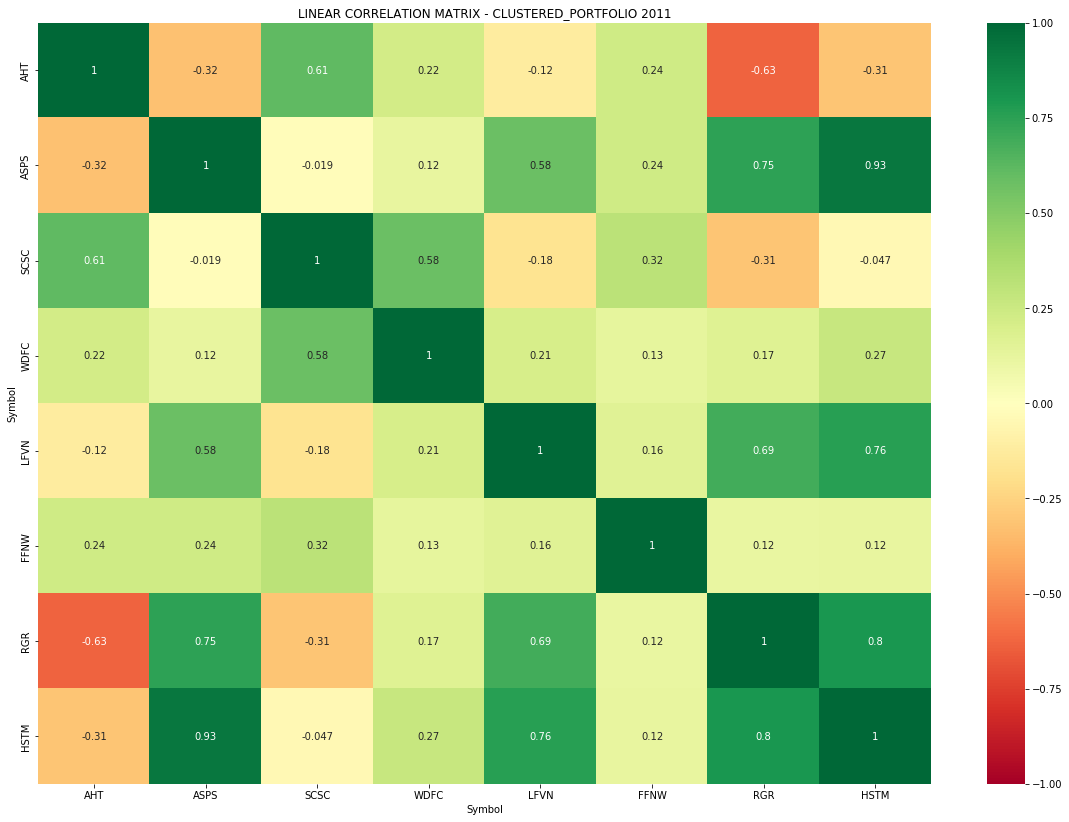

In [103]:
x = result_2011[portfolio2011_tickers]


fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(x.corr(), annot=True, cmap='RdYlGn', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('LINEAR CORRELATION MATRIX - CLUSTERED_PORTFOLIO 2011')
plt.show()

